In [448]:
import gym
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

class tilecoding_Mountain:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    #bins = tuple([bins]*env.observation_space.shape[0])
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    #print(offset_pos)
    min_pos, min_vel  = self.env.observation_space.low
    max_pos, max_vel = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins + 1)[1:-1] + offset_pos[0]
    vel_grid = np.linspace(min_vel, max_vel, bins + 1)[1:-1] + offset_pos[1]

    grid = [pos_grid, vel_grid]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    offset_pos = (self.env.observation_space.high - self.env.observation_space.low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print(tiling_specs)

    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    #print(np.array(encode).flatten())
    return np.array(encode).flatten()#np.array(array_160d).reshape(-1, 4)

In [480]:
class discretize_action:
    def __init__(self, env) -> None:
        self.env = env
        self.action_space = self.env.action_space

    def discretize_action_space(self, steps_per_dimension):
        """
        Discretizes the action space.

        Parameters:
        - low: The lower bound of the action space.
        - high: The higher bound of the action space.
        - steps_per_dimension: Number of discrete steps per dimension.

        Returns:
        - A list of discretized actions.
        """
        low = self.action_space.low
        high = self.action_space.high

        # Generate a range of values for each dimension
        ranges = [np.linspace(low[i], high[i], steps_per_dimension) for i in range(len(low))]
        
        # Create a meshgrid of all possible combinations
        mesh = np.meshgrid(*ranges)
        
        # Reshape the meshgrid to create a list of actions
        self.actions = np.vstack([m.flatten() for m in mesh]).T
        
        return self.actions
    
    def allocate_action(self, action):
        distances = np.linalg.norm(self.actions - action, axis=1)
        nearest_index = np.argmin(distances)
        return self.actions[nearest_index]


class Expected_SARSA_Continuous_Action:
  def __init__(self, env, gamma, num_tiles, bins):
    self.state_num = env.observation_space.shape[0]
    discrete_actions = discretize_action(env)
    action_list = discrete_actions.discretize_action_space(steps_per_dimension)
    self.action_num = len(action_list)
    self.w = np.random.uniform(-0.001, 0.001, (self.state_num*bins*num_tiles, self.action_num))
    self.gamma = gamma

  #define the greedy policy
  def policy(self, states, epsilon):
    if random.uniform(0, 1) < epsilon:
        return np.random.randint(self.action_num)
    else:
        return states.argmax()

  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def update(self, current, target, reward, state, action, alpha, done):
    error = reward + self.gamma * target* (not done) - current
    #print(error)
    self.w[:, action] += alpha * error * state


def Expected_SARSA_Continuous(env, tile, alpha, epsilon,  num_tiles, bins, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    Expected_SAR = Expected_SARSA_Continuous_Action(env, gamma, num_tiles, bins)
    tiling = tile 
    tile_grids = tiling.create_tilings()
    #print(d_state)
    initial_epsilon = epsilon
    epsilon_c = initial_epsilon

    rewards = []
    for i in range(episodes):
      s = env.reset()
      reward_ep = 0
      done = False
      state_encoding = tiling.discretize(s, tile_grids)
      #print(state_encoding)
      state_value = Expected_SAR.apply_weight(state_encoding)
      step = 0

      while not done:
        a = Expected_SAR.policy(state_value, epsilon_c)
        v_i = state_value[a]
        #print(action_list[a])
        s, reward, done,  _ = env.step(action_list[a])
        next_state = tiling.discretize(s, tile_grids)
        v_next = epsilon_c * np.mean(Expected_SAR.apply_weight(next_state)) + (1 - epsilon_c) * np.max(Expected_SAR.apply_weight(next_state))
        Expected_SAR.update(v_i, v_next, reward, state_encoding, a, alpha, done)
        state_encoding = next_state
        state_value = Expected_SAR.apply_weight(state_encoding)
        reward_ep += reward
        step += 1
      if epsilon_c > 0.1:
        epsilon_c -= 0.0004
      rewards.append(reward_ep)
      print(f'episode:{i}, reward: {reward_ep}, step: {step}, epsilon: {epsilon_c}')
    trial_reward.append(rewards)

  return trial_reward

In [481]:
env = gym.make("MountainCarContinuous-v0")
env._max_episode_steps = 1000
obs = env.reset()

#define the parameters
epsilon = [0.9]
bins = 5
num_tiles = 2
alpha = [1e-3] #, 5e-4, 1e-4]
steps_per_dimension = 5
discrete_actions = discretize_action(env)
action_list = discrete_actions.discretize_action_space(steps_per_dimension)
#print(action_list)
trials = 20
gamma = 0.7
episodes = 1000

In [482]:
MCC_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for i in range(len(epsilon)):
    avg_return = Expected_SARSA_Continuous(env, tilecoding_Mountain(env, num_tiles, bins), alpha[j], epsilon[i],num_tiles, bins)
    learning_return_SARSA.append(avg_return)
  MCC_epsilon_return_SARSA.append(learning_return_SARSA)

episode:0, reward: -43.22500000000001, step: 1000, epsilon: 0.8996000000000001
episode:1, reward: -45.72499999999996, step: 1000, epsilon: 0.8992000000000001
episode:2, reward: -44.45, step: 1000, epsilon: 0.8988000000000002
episode:3, reward: -42.125, step: 1000, epsilon: 0.8984000000000002
episode:4, reward: -47.650000000000034, step: 1000, epsilon: 0.8980000000000002
episode:5, reward: -46.95, step: 1000, epsilon: 0.8976000000000003
episode:6, reward: -47.60000000000006, step: 1000, epsilon: 0.8972000000000003
episode:7, reward: -44.60000000000006, step: 1000, epsilon: 0.8968000000000004
episode:8, reward: -44.92500000000002, step: 1000, epsilon: 0.8964000000000004
episode:9, reward: -44.299999999999955, step: 1000, epsilon: 0.8960000000000005
episode:10, reward: -47.50000000000003, step: 1000, epsilon: 0.8956000000000005
episode:11, reward: -45.624999999999986, step: 1000, epsilon: 0.8952000000000006
episode:12, reward: -45.40000000000004, step: 1000, epsilon: 0.8948000000000006
ep

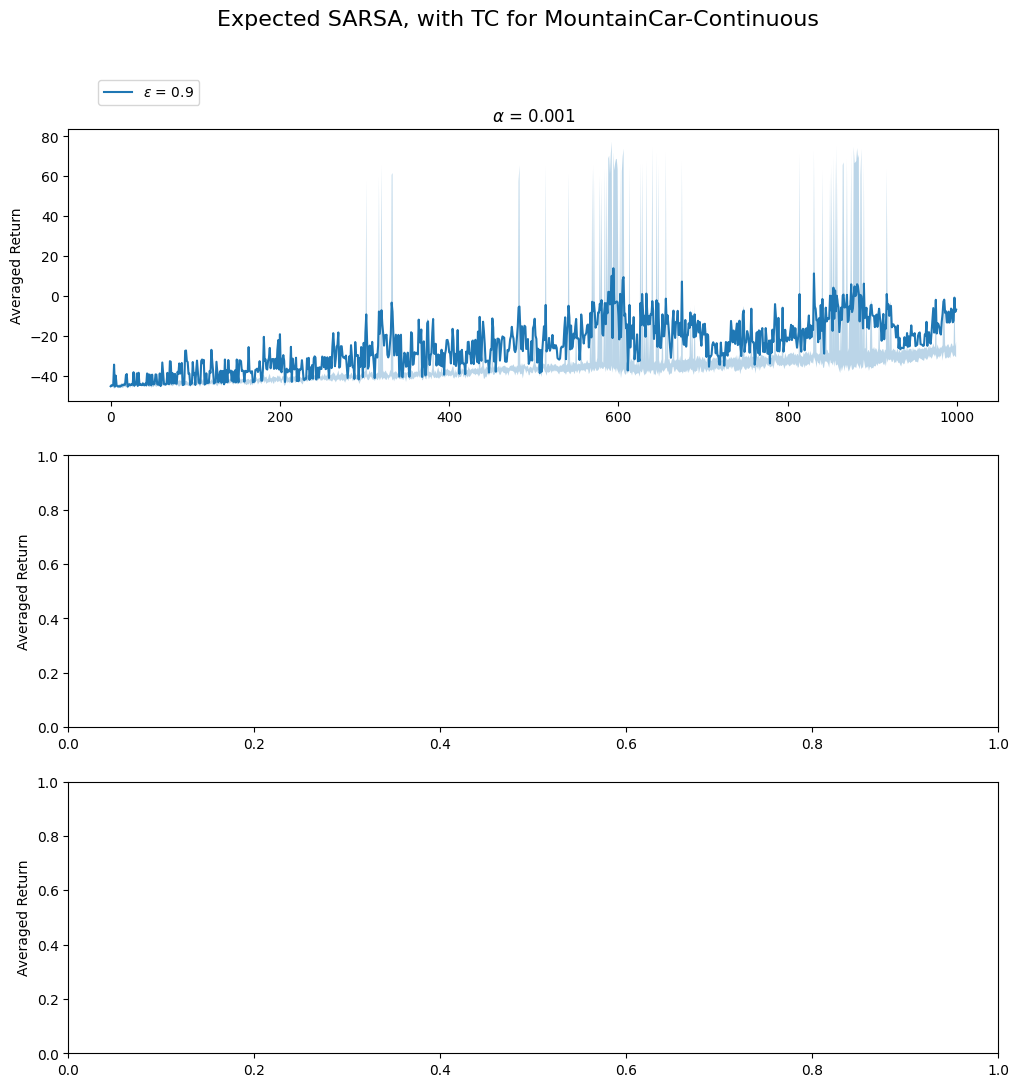

In [483]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(MCC_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA, with TC for MountainCar-Continuous', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)

In [ ]:
import os
import pickle

pkl_path = './Expected_SARSA/MC/'
os.makedirs(pkl_path, exist_ok=True)

dataStore = {}
for i, learning in enumerate(MCC_epsilon_return_SARSA):
    dataStore[alpha[i]] = {}
    for j, alpha_data in enumerate(learning):
        dataStore[alpha[i]][epsilon[j]] = alpha_data
    
with open(pkl_path + 'Results_ES_TC_MCC_2' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
